313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9723 - loss: 0.0919
Test accuracy on clean images: 0.9757999777793884


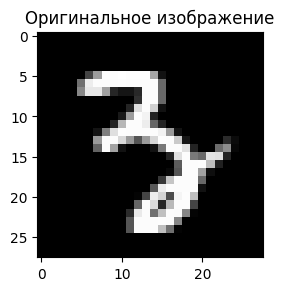

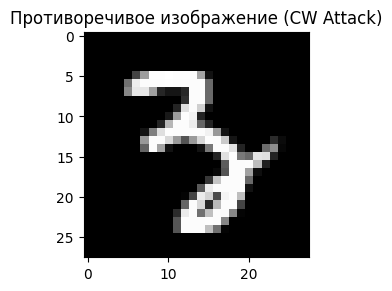

Evaluating model on adversarial examples...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0927 - loss: 2.3856
Accuracy on adversarial examples (CW attack): 0.08399999886751175


In [ ]:
%pip install foolbox
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация изображений и преобразование меток
test_images = test_images / 255.0
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка предварительно обученной модели
model = tf.keras.models.load_model('/content/sample_data/mnist_model.h5')

# Оценка модели на чистых данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Генерация одного контрпримера
image = tf.convert_to_tensor(test_images[87][None, ...], dtype=tf.float32)
label = tf.convert_to_tensor(np.argmax(test_labels[87]), dtype=tf.int64)

attack = fb.attacks.L2CarliniWagnerAttack(steps=2)
eager_adversarial, _, success = attack(fmodel, image, label[None], epsilons=0.01)

# Проверка содержимого контрпримера
if eager_adversarial is not None and np.any(eager_adversarial[0].numpy()):
    adversarial_image = eager_adversarial[0].numpy()
else:
    adversarial_image = np.zeros_like(image[0].numpy())

# Визуализация исходного и контрпримера
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")

plt.figure()
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (CW Attack)")
plt.imshow(adversarial_image, cmap="gray")
plt.show()

# Генерация контрпримеров для части тестовых изображен
adversarial_images = []
num_samples = 1000  # изменено количество обрабатываемых изображений для ускорения подсчетов

for i, (img, lbl) in enumerate(zip(test_images[:num_samples], test_labels[:num_samples])):
    image = tf.convert_to_tensor(img[None, ...], dtype=tf.float32)
    label = tf.convert_to_tensor(np.argmax(lbl), dtype=tf.int64)
    eager_adversarial, _, success = attack(fmodel, image, label[None], epsilons=0.01)
    if eager_adversarial is not None:
        adversarial_images.append(eager_adversarial[0].numpy())
    else:
        adversarial_images.append(np.zeros_like(img))

adversarial_images = np.array(adversarial_images)

# Оценка модели на контрпримерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[:num_samples])
print(f'Accuracy on adversarial examples (CW attack): {adversarial_acc}')



Вывод: точность модели значительно снизилась (с 98% до 8%) даже при небольших изменениях входных данных.